# CTGAN Model Creator
Этот ноутбук автоматически создает CTGAN модели для всех датасетов и методов кодирования

In [1]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import ast
import os
import traceback

## 1. Функции для работы с реестром датасетов

In [2]:
def load_datasets_registry(registry_path='datasets/datasets_registry.csv'):
    """
    Загружает реестр датасетов и преобразует его в список структур.
    
    Args:
        registry_path: путь к файлу datasets_registry.csv
    
    Returns:
        list: список словарей с информацией о датасетах
    """
    df = pd.read_csv(registry_path, skipinitialspace=True)
    
    datasets_list = []
    for _, row in df.iterrows():
        if pd.isna(row['cat_col']):
            cat_cols_list = []
        else:
            cat_col_str = str(row['cat_col']).replace('\n', '').replace('\r', '').strip()
            try:
                if cat_col_str:
                    cat_cols_list = ast.literal_eval(cat_col_str)
                else:
                    cat_cols_list = []
            except (ValueError, SyntaxError):
                cat_cols_list = []
        
        dataset_info = {
            'dataset_name': row['dataset_name'].strip(),
            'dataset_path': row['dataset_path'].strip(),
            'dataset_csv': row['dataset_csv'].strip(),
            'target': row['target'].strip(),
            'cat_cols': cat_cols_list
        }
        datasets_list.append(dataset_info)
    
    return datasets_list

In [3]:
def load_encoded_datasets(dataset_info):
    """
    Загружает информацию о закодированных версиях датасета из data.csv.
    
    Args:
        dataset_info: словарь с информацией о датасете
    
    Returns:
        list: список словарей с информацией о закодированных датасетах
    """
    data_csv_path = Path(dataset_info['dataset_csv'])
    
    if not os.path.exists(data_csv_path):
        print(f"  ⚠️ Файл {data_csv_path} не найден")
        return []
    
    df = pd.read_csv(data_csv_path)
    
    encoded_datasets = []
    for _, row in df.iterrows():
        try:
            new_cat_cols = ast.literal_eval(str(row['New_cat_cols']))
        except:
            new_cat_cols = []
        
        encoded_info = {
            'method': row['method'],
            'path': row['path'],
            'New_cat_cols': new_cat_cols,
            'model_path': row.get('model_path', ''),
            'schedul_path': row.get('schedul_path', ''),
            'dataset_name': dataset_info['dataset_name'],
            'dataset_folder': Path(dataset_info['dataset_csv']).parent
        }
        encoded_datasets.append(encoded_info)
    
    return encoded_datasets

## 2. Функция для визуализации лоссов

In [4]:
def plot_ctgan_losses(loss_df: pd.DataFrame, smooth_window: int = 10, save_path: str = None):
    """
    Красивый график лоссов CTGAN.
    
    Args:
        loss_df: DataFrame из ctgan.loss_values
        smooth_window: окно сглаживания (эпох)
        save_path: если задан, сохранить PNG по этому пути
    """
    if loss_df is None or len(loss_df) == 0:
        print("  ⚠️ График не может быть построен: DataFrame с лоссами пуст.")
        return

    # Пытаемся угадать имена столбцов (гибкий поиск)
    cols_lower = {c.lower(): c for c in loss_df.columns}
    g_col_name = next((c for c in cols_lower if "gen" in c), None)
    d_col_name = next((c for c in cols_lower if "dis" in c), None)

    g_col = cols_lower.get(g_col_name)
    d_col = cols_lower.get(d_col_name)

    # Фоллбэк: берем первые два столбца
    if g_col is None or d_col is None:
        if len(loss_df.columns) < 2:
            print(f"  ⚠️ График не может быть построен: loss_df должен содержать хотя бы 2 столбца (G и D), найдено {len(loss_df.columns)}")
            return
        g_col, d_col = loss_df.columns[:2]

    # Индекс эпох (начнем с 1)
    epochs = np.arange(1, len(loss_df) + 1)

    # Приводим к float на всякий случай
    df = loss_df.copy()
    for c in [g_col, d_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Сглаживание
    g_smooth = df[g_col].rolling(smooth_window, min_periods=1).mean()
    d_smooth = df[d_col].rolling(smooth_window, min_periods=1).mean()

    plt.figure(figsize=(10, 6), dpi=120)

    # Тонкие «сырые» линии
    plt.plot(epochs, df[g_col], alpha=0.25, linewidth=1, label=f"{g_col} (raw)")
    plt.plot(epochs, df[d_col], alpha=0.25, linewidth=1, label=f"{d_col} (raw)")

    # Толстые сглаженные
    plt.plot(epochs, g_smooth, linewidth=2.5, label=f"{g_col} (smoothed)")
    plt.plot(epochs, d_smooth, linewidth=2.5, label=f"{d_col} (smoothed)")

    # Аннотации: последние значения и минимумы
    def annotate_series(y, name):
        if y.empty or y.isnull().all(): return
        y_last = float(y.iloc[-1])
        y_min = float(y.min())
        x_min = int(y.idxmin()) + 1
        plt.scatter([len(y)], [y_last], s=30)
        plt.text(len(y), y_last, f"  last: {y_last:.3f}", va="center")
        plt.scatter([x_min], [y_min], s=30)
        plt.text(x_min, y_min, f"  min@{x_min}: {y_min:.3f}", va="center")

    annotate_series(g_smooth, g_col)
    annotate_series(d_smooth, d_col)

    plt.title("CTGAN Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

## 3. Функция для тренировки CTGAN

In [5]:
def train_ctgan_for_encoded_dataset(encoded_info, epochs=300, verbose=True):
    """
    Тренирует CTGAN модель для закодированного датасета.
    
    Args:
        encoded_info: словарь с информацией о закодированном датасете
        epochs: количество эпох для обучения
        verbose: выводить ли прогресс обучения
    
    Returns:
        tuple: (ctgan_model, loss_df) или (None, None) в случае ошибки
    """
    try:
        data_path = Path(encoded_info['path'])
        print(f"\n{'='*70}")
        print(f"📊 Датасет: {encoded_info['dataset_name']}")
        print(f"🔧 Метод: {encoded_info['method']}")
        print(f"📁 Путь: {data_path}")
        
        if not os.path.exists(data_path):
            print(f"  ⚠️ Файл {data_path} не найден, пропускаем")
            return None, None
        
        df = pd.read_csv(data_path)
        print(f"  ✅ Загружено {len(df)} строк, {len(df.columns)} колонок")
        
        discrete_features = encoded_info['New_cat_cols']
        discrete_features = [col for col in discrete_features if col in df.columns]
        print(f"  🏷️ Дискретных признаков: {len(discrete_features)}")
        
        print(f"  🚀 Начинаем обучение CTGAN ({epochs} эпох)...")
        ctgan = CTGAN(
            epochs=epochs,
            verbose=verbose
        )
        ctgan.fit(df, discrete_features)
        
        loss_df = ctgan.loss_values
        print(f"  ✅ Обучение завершено!")
        
        return ctgan, loss_df
        
    except Exception as e:
        print(f"  ❌ Ошибка при обучении: {e}")
        traceback.print_exc()
        return None, None

In [6]:
def save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path):
    """
    Сохраняет модель, график лоссов и обновляет data.csv.
    
    Args:
        ctgan: обученная модель CTGAN
        loss_df: DataFrame с лоссами
        encoded_info: словарь с информацией о закодированном датасете
        data_csv_path: путь к data.csv
    """
    try:
        dataset_folder = encoded_info['dataset_folder']
        dataset_name = encoded_info['dataset_name']
        method = encoded_info['method']

        models_folder = dataset_folder / 'models'
        schedules_folder = dataset_folder / 'training_schedules'
        models_folder.mkdir(exist_ok=True)
        schedules_folder.mkdir(exist_ok=True)

        model_filename = f"ctgan_{dataset_name}_{method}_model.pkl"
        schedule_filename = f"ctgan_{dataset_name}_{method}_losses.png"

        model_path = models_folder / model_filename
        schedule_path = schedules_folder / schedule_filename

        ctgan.save(str(model_path))
        print(f"  💾 Модель сохранена: {model_path}")

        if loss_df is not None and not loss_df.empty:
            plot_ctgan_losses(loss_df, save_path=str(schedule_path))
            print(f"  📈 График сохранен: {schedule_path}")
        else:
            print("  ⚠️ Пропускаем сохранение графика: нет данных о лоссах.")
            schedule_path = None

        df = pd.read_csv(data_csv_path)

        if 'model_path' not in df.columns:
            df['model_path'] = ''
        if 'schedul_path' not in df.columns:
            df['schedul_path'] = ''

        mask = df['method'] == method

        model_rel_path = str(model_path)
        schedule_rel_path = str(schedule_path) if schedule_path else ''

        df.loc[mask, 'model_path'] = model_rel_path
        df.loc[mask, 'schedul_path'] = schedule_rel_path

        df.to_csv(data_csv_path, index=False)
        print(f"  📝 Обновлен {data_csv_path}")

    except Exception as e:
        print(f"  ❌ Ошибка при сохранении: {e}")
        traceback.print_exc()

## 4. Главная функция для обработки всех датасетов

In [7]:
def process_all_datasets(epochs=300, verbose=True):
    """
    Обрабатывает все датасеты из реестра.
    
    Args:
        epochs: количество эпох для обучения каждой модели
        verbose: выводить ли прогресс обучения
    """
    print("="*70)
    print("🚀 CTGAN Model Creator")
    print("="*70)
    
    datasets = load_datasets_registry()
    print(f"\n📋 Загружено датасетов: {len(datasets)}")
    
    total_models = 0
    successful_models = 0
    
    for dataset_info in datasets:
        print(f"\n{'='*70}")
        print(f"📦 Обработка датасета: {dataset_info['dataset_name']}")
        print(f"{'='*70}")
        
        encoded_datasets = load_encoded_datasets(dataset_info)
        print(f"  📊 Найдено закодированных версий: {len(encoded_datasets)}")
        
        if len(encoded_datasets) == 0:
            print(f"  ⚠️ Пропускаем датасет (нет закодированных версий)")
            continue
        
        for encoded_info in encoded_datasets:
            total_models += 1
            
            ctgan, loss_df = train_ctgan_for_encoded_dataset(
                encoded_info, 
                epochs=epochs, 
                verbose=verbose
            )
            
            if ctgan is not None:
                data_csv_path = Path(dataset_info['dataset_csv'])
                save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path)
                successful_models += 1
    
    print(f"\n{'='*70}")
    print(f"✅ ЗАВЕРШЕНО!")
    print(f"{'='*70}")
    print(f"  Всего моделей для обучения: {total_models}")
    print(f"  Успешно обучено: {successful_models}")
    print(f"  Ошибок: {total_models - successful_models}")
    print(f"{'='*70}")

## 5. Запуск обработки

In [8]:
datasets = load_datasets_registry()
print(f"Загружено датасетов: {len(datasets)}")
print("\nСписок датасетов:")
for ds in datasets:
    print(f"  - {ds['dataset_name']}")

Загружено датасетов: 2

Список датасетов:
  - adult
  - magic_gamma


In [9]:
if len(datasets) > 0:
    encoded = load_encoded_datasets(datasets[0])
    print(f"\nЗакодированные версии для '{datasets[0]['dataset_name']}':")
    for enc in encoded:
        print(f"  - {enc['method']}: {enc['path']}")
        print(f"    Дискретных колонок: {len(enc['New_cat_cols'])}")


Закодированные версии для 'adult':
  - one_hot_encoding: datasets/adult/adult_ohe.csv
    Дискретных колонок: 98
  - label_encoding: datasets/adult/adult_label.csv
    Дискретных колонок: 9
  - frequency_encoding: datasets/adult/adult_frequency.csv
    Дискретных колонок: 9
  - original: datasets/adult/adult_original.csv
    Дискретных колонок: 1


🚀 CTGAN Model Creator

📋 Загружено датасетов: 2

📦 Обработка датасета: adult
  📊 Найдено закодированных версий: 4

📊 Датасет: adult
🔧 Метод: one_hot_encoding
📁 Путь: datasets/adult/adult_ohe.csv
  ✅ Загружено 10000 строк, 104 колонок
  🏷️ Дискретных признаков: 98
  🚀 Начинаем обучение CTGAN (3 эпох)...


Gen. (-6.74) | Discrim. (0.42): 100%|██████████| 3/3 [00:05<00:00,  1.75s/it] 


  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/adult/models/ctgan_adult_one_hot_encoding_model.pkl


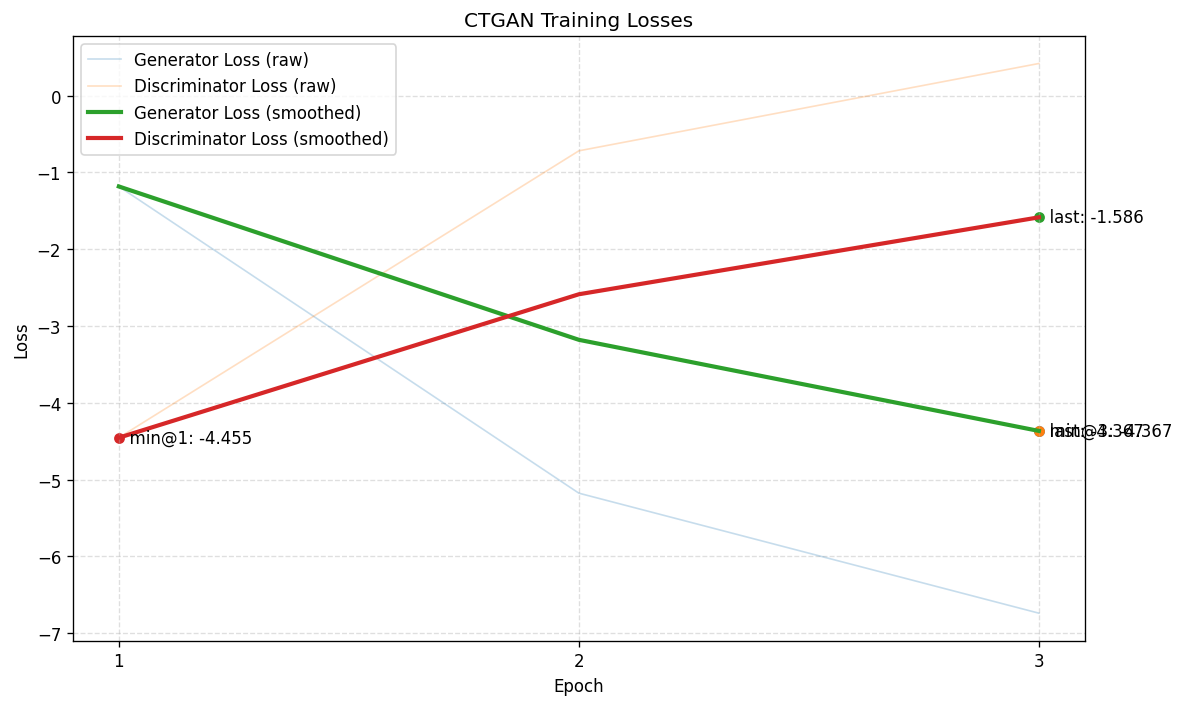

  📈 График сохранен: datasets/adult/training_schedules/ctgan_adult_one_hot_encoding_losses.png
  📝 Обновлен datasets/adult/data.csv

📊 Датасет: adult
🔧 Метод: label_encoding
📁 Путь: datasets/adult/adult_label.csv
  ✅ Загружено 10000 строк, 15 колонок
  🏷️ Дискретных признаков: 9
  🚀 Начинаем обучение CTGAN (3 эпох)...


/var/folders/j4/sccx6ys16c3927wv6rvgtn3c0000gn/T/ipykernel_14557/3468594800.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'datasets/adult/models/ctgan_adult_one_hot_encoding_model.pkl' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'model_path'] = model_rel_path
/var/folders/j4/sccx6ys16c3927wv6rvgtn3c0000gn/T/ipykernel_14557/3468594800.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'datasets/adult/training_schedules/ctgan_adult_one_hot_encoding_losses.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'schedul_path'] = schedule_rel_path
Gen. (2.07) | Discrim. (-0.31): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/adult/models/ctgan_adult_label_encoding_model.pkl


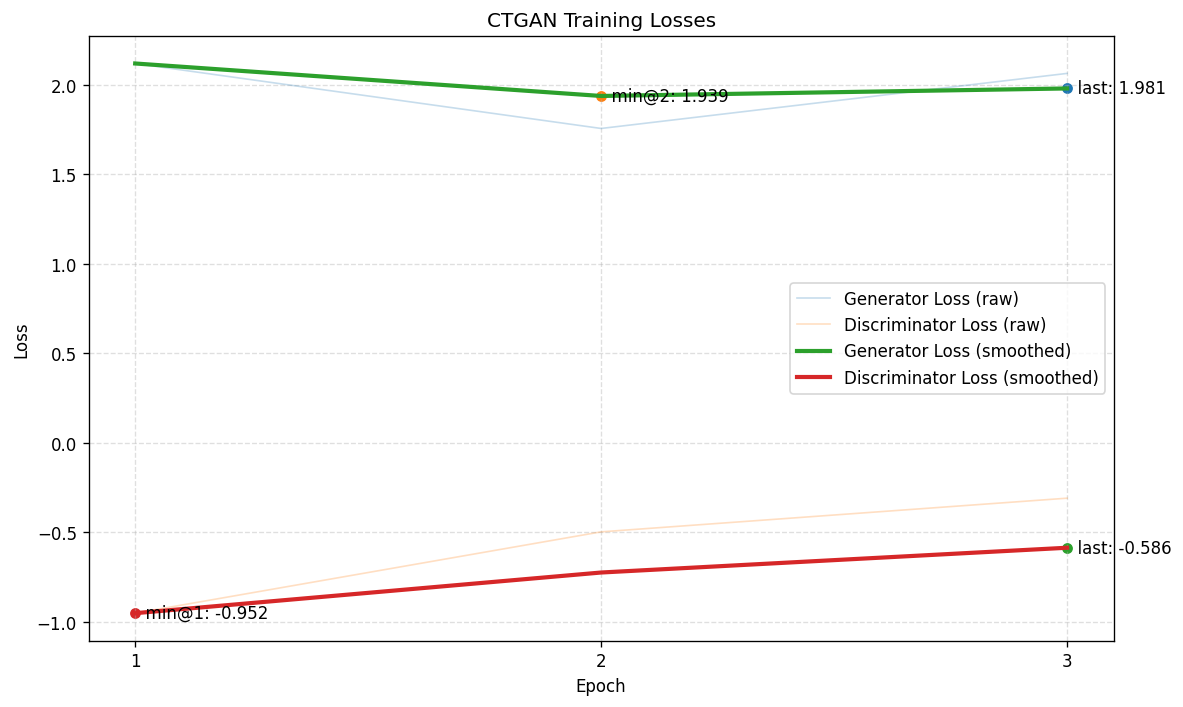

  📈 График сохранен: datasets/adult/training_schedules/ctgan_adult_label_encoding_losses.png
  📝 Обновлен datasets/adult/data.csv

📊 Датасет: adult
🔧 Метод: frequency_encoding
📁 Путь: datasets/adult/adult_frequency.csv
  ✅ Загружено 10000 строк, 15 колонок
  🏷️ Дискретных признаков: 9
  🚀 Начинаем обучение CTGAN (3 эпох)...


Gen. (1.65) | Discrim. (-0.16): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/adult/models/ctgan_adult_frequency_encoding_model.pkl


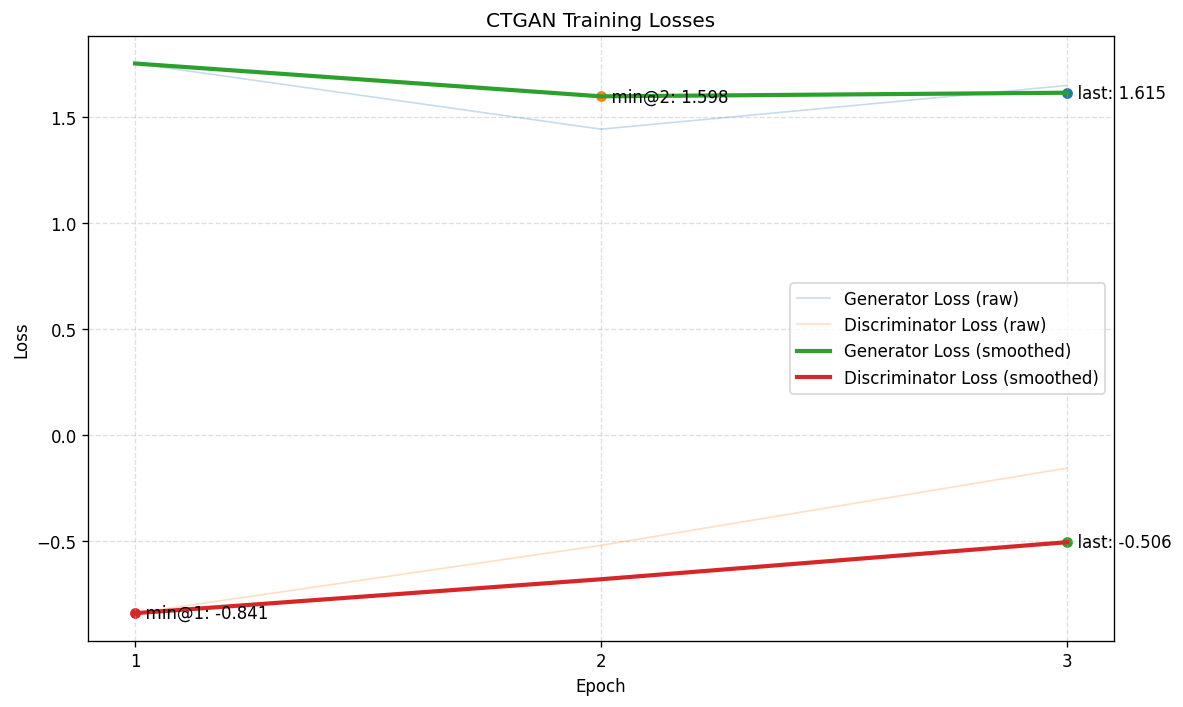

  📈 График сохранен: datasets/adult/training_schedules/ctgan_adult_frequency_encoding_losses.png
  📝 Обновлен datasets/adult/data.csv

📊 Датасет: adult
🔧 Метод: original
📁 Путь: datasets/adult/adult_original.csv
  ✅ Загружено 10000 строк, 15 колонок
  🏷️ Дискретных признаков: 1
  🚀 Начинаем обучение CTGAN (3 эпох)...
  ❌ Ошибка при обучении: Could not convert string 'Self-emp-not-incPrivatePrivatePrivateLocal-govSelf-emp-not-incPrivatePrivateLocal-govPrivatePrivateSelf-emp-not-incPrivatePrivateSelf-emp-not-incPrivatePrivatePrivatePrivateSelf-emp-not-incPrivatePrivateState-govPrivateLocal-govPrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivateSelf-emp-not-incFederal-govPrivatePrivatePrivatePrivatePrivateLocal-govState-govPrivatePrivatePrivateState-govPrivatePrivatePrivatePrivatePrivatePrivatePrivateState-govPrivatePrivatePrivatePrivatePrivateLocal-govPrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivateSelf-emp-not-incPrivatePrivat

Traceback (most recent call last):
  File "/var/folders/j4/sccx6ys16c3927wv6rvgtn3c0000gn/T/ipykernel_14557/252442065.py", line 36, in train_ctgan_for_encoded_dataset
    ctgan.fit(df, discrete_features)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hatiko/PycharmProjects/JupyterProject/.venv/lib/python3.13/site-packages/ctgan/synthesizers/base.py", line 50, in wrapper
    return function(self, *args, **kwargs)
  File "/Users/hatiko/PycharmProjects/JupyterProject/.venv/lib/python3.13/site-packages/ctgan/synthesizers/ctgan.py", line 346, in fit
    self._transformer.fit(train_data, discrete_columns)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hatiko/PycharmProjects/JupyterProject/.venv/lib/python3.13/site-packages/ctgan/data_transformer.py", line 113, in fit
    column_transform_info = self._fit_continuous(raw_data[[column_name]])
  File "/Users/hatiko/PycharmProjects/JupyterProject/.venv/lib/python3.13/site-packages/ctgan/data_transformer.py", line 53, 

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/magic_gamma/models/ctgan_magic_gamma_one_hot_encoding_model.pkl


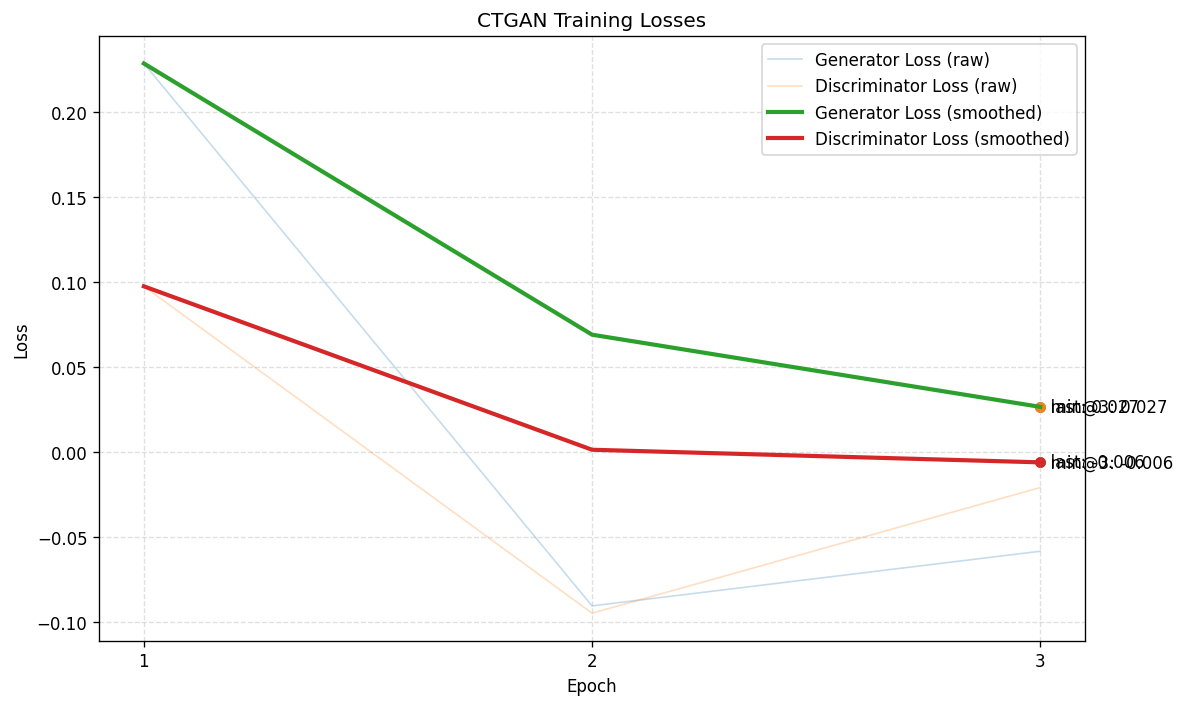

/var/folders/j4/sccx6ys16c3927wv6rvgtn3c0000gn/T/ipykernel_14557/3468594800.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'datasets/magic_gamma/models/ctgan_magic_gamma_one_hot_encoding_model.pkl' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'model_path'] = model_rel_path
/var/folders/j4/sccx6ys16c3927wv6rvgtn3c0000gn/T/ipykernel_14557/3468594800.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'datasets/magic_gamma/training_schedules/ctgan_magic_gamma_one_hot_encoding_losses.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'schedul_path'] = schedule_rel_path


  📈 График сохранен: datasets/magic_gamma/training_schedules/ctgan_magic_gamma_one_hot_encoding_losses.png
  📝 Обновлен datasets/magic_gamma/data.csv

📊 Датасет: magic_gamma
🔧 Метод: label_encoding
📁 Путь: datasets/magic_gamma/magic_gamma_label.csv
  ✅ Загружено 10000 строк, 11 колонок
  🏷️ Дискретных признаков: 1
  🚀 Начинаем обучение CTGAN (3 эпох)...


Gen. (0.02) | Discrim. (-0.11): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/magic_gamma/models/ctgan_magic_gamma_label_encoding_model.pkl


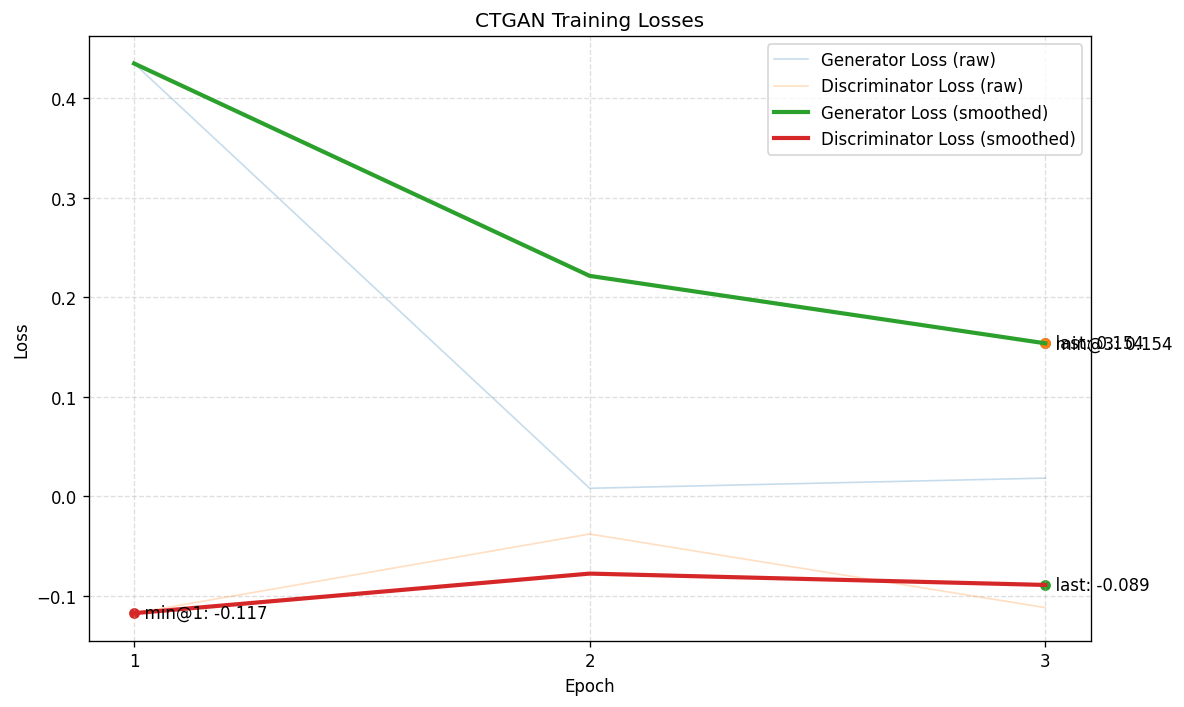

  📈 График сохранен: datasets/magic_gamma/training_schedules/ctgan_magic_gamma_label_encoding_losses.png
  📝 Обновлен datasets/magic_gamma/data.csv

📊 Датасет: magic_gamma
🔧 Метод: frequency_encoding
📁 Путь: datasets/magic_gamma/magic_gamma_frequency.csv
  ✅ Загружено 10000 строк, 11 колонок
  🏷️ Дискретных признаков: 1
  🚀 Начинаем обучение CTGAN (3 эпох)...


Gen. (-0.18) | Discrim. (-0.05): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/magic_gamma/models/ctgan_magic_gamma_frequency_encoding_model.pkl


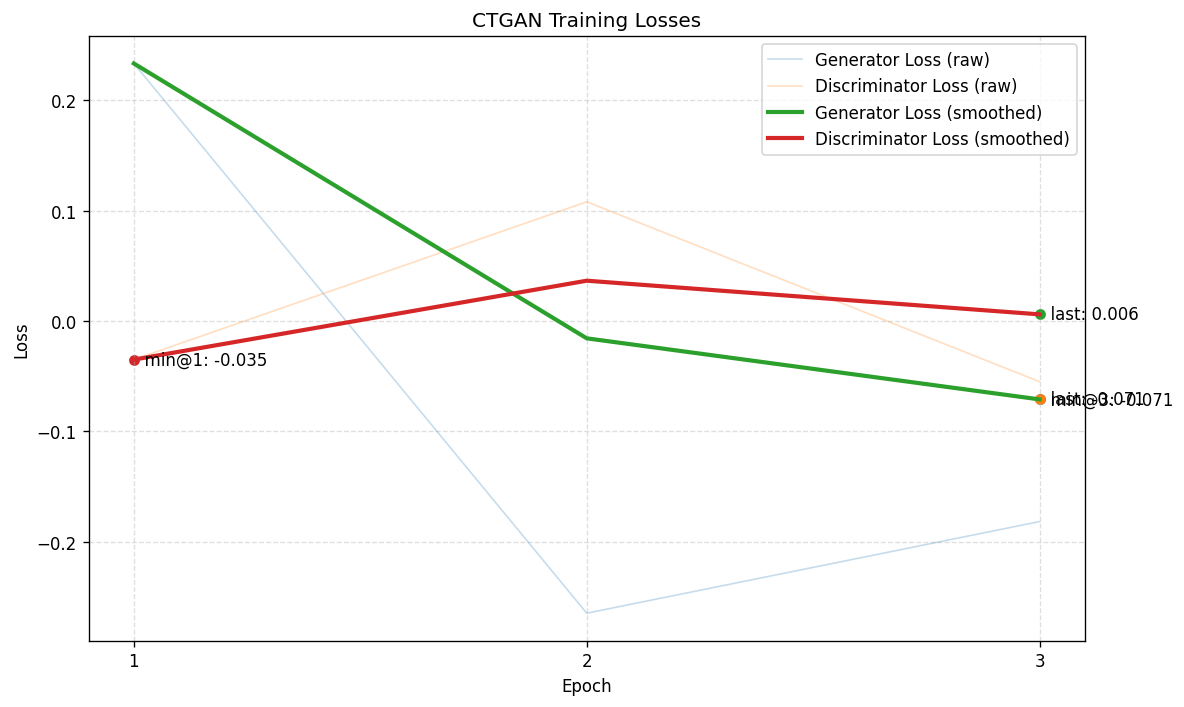

  📈 График сохранен: datasets/magic_gamma/training_schedules/ctgan_magic_gamma_frequency_encoding_losses.png
  📝 Обновлен datasets/magic_gamma/data.csv

📊 Датасет: magic_gamma
🔧 Метод: original
📁 Путь: datasets/magic_gamma/magic_gamma_original.csv
  ✅ Загружено 10000 строк, 11 колонок
  🏷️ Дискретных признаков: 1
  🚀 Начинаем обучение CTGAN (3 эпох)...


Gen. (-0.33) | Discrim. (0.00): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

  ✅ Обучение завершено!
  💾 Модель сохранена: datasets/magic_gamma/models/ctgan_magic_gamma_original_model.pkl


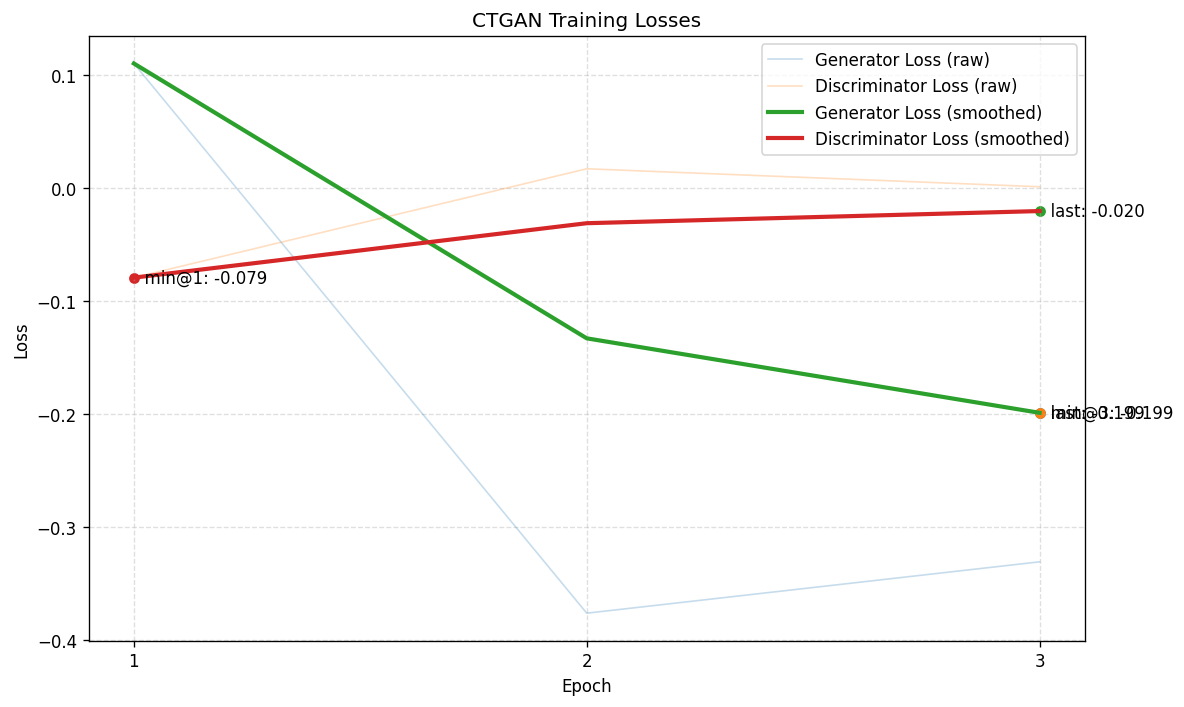

  📈 График сохранен: datasets/magic_gamma/training_schedules/ctgan_magic_gamma_original_losses.png
  📝 Обновлен datasets/magic_gamma/data.csv

✅ ЗАВЕРШЕНО!
  Всего моделей для обучения: 8
  Успешно обучено: 7
  Ошибок: 1


In [11]:
# ЗАПУСК: Обработка всех датасетов
# Параметры:
# - epochs: количество эпох обучения (по умолчанию 300)
# - verbose: выводить прогресс (True/False)

process_all_datasets(epochs=3, verbose=True)

## 6. Дополнительные утилиты

In [12]:
def train_single_dataset(dataset_name, method, epochs=300):
    """
    Обучает модель для конкретного датасета и метода кодирования.
    
    Args:
        dataset_name: имя датасета (например, 'adult')
        method: метод кодирования (например, 'one_hot_encoding')
        epochs: количество эпох
    """
    datasets = load_datasets_registry()
    
    dataset_info = next((ds for ds in datasets if ds['dataset_name'] == dataset_name), None)
    
    if dataset_info is None:
        print(f"❌ Датасет '{dataset_name}' не найден")
        return
    
    encoded_datasets = load_encoded_datasets(dataset_info)
    
    encoded_info = next((enc for enc in encoded_datasets if enc['method'] == method), None)
    
    if encoded_info is None:
        print(f"❌ Метод '{method}' не найден для датасета '{dataset_name}'")
        print(f"Доступные методы: {[enc['method'] for enc in encoded_datasets]}")
        return
    
    ctgan, loss_df = train_ctgan_for_encoded_dataset(encoded_info, epochs=epochs, verbose=True)
    
    if ctgan is not None:
        data_csv_path = Path(dataset_info['dataset_csv'])
        save_ctgan_results(ctgan, loss_df, encoded_info, data_csv_path)
        print(f"\n✅ Модель успешно обучена и сохранена!")
    else:
        print(f"\n❌ Ошибка при обучении модели")

In [ ]:
# Пример использования: обучить одну модель
# train_single_dataset('adult', 'one_hot_encoding', epochs=500)

## 7. Просмотр результатов

In [15]:
def show_results_summary():
    """
    Выводит сводку по всем обученным моделям.
    """
    datasets = load_datasets_registry()
    
    print("="*100)
    print("📊 СВОДКА ПО ОБУЧЕННЫМ МОДЕЛЯМ")
    print("="*100)
    
    for dataset_info in datasets:
        data_csv_path = Path(dataset_info['dataset_csv'])
        
        if not os.path.exists(data_csv_path):
            continue
        
        # При чтении CSV сразу заменяем возможные NaN на пустые строки
        df = pd.read_csv(data_csv_path).fillna('')

        print(f"\n📦 {dataset_info['dataset_name'].upper()}")
        print("-"*100)

        for _, row in df.iterrows():
            method = row['method']
            # Теперь эти значения гарантированно будут строками
            model_path = row.get('model_path', '')
            schedule_path = row.get('schedul_path', '')

            model_exists = "✅" if model_path and os.path.exists(Path(model_path)) else "❌"
            schedule_exists = "✅" if schedule_path and os.path.exists(Path(schedule_path)) else "❌"

            print(f"  {method:20s} | Модель: {model_exists} | График: {schedule_exists}")
            if model_path:
                print(f"    └─ Модель: {model_path}")
            if schedule_path:
                print(f"    └─ График: {schedule_path}")


In [16]:
# Показать сводку по всем моделям
show_results_summary()

📊 СВОДКА ПО ОБУЧЕННЫМ МОДЕЛЯМ

📦 ADULT
----------------------------------------------------------------------------------------------------
  one_hot_encoding     | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_one_hot_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_one_hot_encoding_losses.png
  label_encoding       | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_label_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_label_encoding_losses.png
  frequency_encoding   | Модель: ✅ | График: ✅
    └─ Модель: datasets/adult/models/ctgan_adult_frequency_encoding_model.pkl
    └─ График: datasets/adult/training_schedules/ctgan_adult_frequency_encoding_losses.png
  original             | Модель: ❌ | График: ❌

📦 MAGIC_GAMMA
----------------------------------------------------------------------------------------------------
  one_hot_encoding     | Модель: ✅ | График: ✅
    └─ Модель:

## 6. Карточки, метрики и отчет

Эта секция синхронизирует результаты обучения CTGAN с реестром датасетов, рассчитывает метрики качества (Jensen–Shannon divergence и utility для Logistic Regression/XGBoost) и формирует HTML-отчет.

In [ ]:

from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
try:
    from xgboost import XGBClassifier
except ImportError:  # на случай отсутствия зависимости
    XGBClassifier = None


def _safe_parse_list(value):
    if pd.isna(value):
        return []
    try:
        return ast.literal_eval(str(value))
    except Exception:
        return []


def _prepare_xy(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series]:
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in dataframe")
    X = df.drop(columns=[target]).copy()
    y = df[target].copy()

    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            X[col] = pd.factorize(X[col])[0]
    if not pd.api.types.is_numeric_dtype(y):
        y = pd.factorize(y)[0]
    return X, y


def _jensen_shannon(p: np.ndarray, q: np.ndarray) -> float:
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    p = np.where(p == 0, 1e-12, p)
    q = np.where(q == 0, 1e-12, q)
    m = np.where(m == 0, 1e-12, m)
    kl_pm = np.sum(p * np.log(p / m))
    kl_qm = np.sum(q * np.log(q / m))
    return float(0.5 * (kl_pm + kl_qm))


def compute_column_js(real: pd.Series, synth: pd.Series, bins: int = 20) -> Optional[float]:
    real = real.dropna()
    synth = synth.dropna()
    if real.empty or synth.empty:
        return None

    if pd.api.types.is_numeric_dtype(real) and pd.api.types.is_numeric_dtype(synth):
        bins_edges = np.histogram_bin_edges(pd.concat([real, synth]), bins=bins)
        r_hist, _ = np.histogram(real, bins=bins_edges, density=True)
        s_hist, _ = np.histogram(synth, bins=bins_edges, density=True)
    else:
        categories = list(set(real.astype(str)).union(set(synth.astype(str))))
        r_counts = real.astype(str).value_counts().reindex(categories, fill_value=0)
        s_counts = synth.astype(str).value_counts().reindex(categories, fill_value=0)
        r_hist = r_counts.to_numpy(dtype=float)
        s_hist = s_counts.to_numpy(dtype=float)

    if r_hist.sum() == 0 or s_hist.sum() == 0:
        return None
    return _jensen_shannon(r_hist, s_hist)


def compute_dataset_js(real_df: pd.DataFrame, synth_df: pd.DataFrame) -> Optional[float]:
    cols = [c for c in real_df.columns if c in synth_df.columns]
    js_values = []
    for col in cols:
        js_val = compute_column_js(real_df[col], synth_df[col])
        if js_val is not None and not np.isnan(js_val):
            js_values.append(js_val)
    if not js_values:
        return None
    return float(np.mean(js_values))


def compute_utility_scores(real_df: pd.DataFrame, synth_df: pd.DataFrame, target: str) -> dict:
    results = {
        "utility_logistic": None,
        "utility_xgboost": None,
        "baseline_logistic": None,
        "baseline_xgboost": None,
    }

    try:
        X_real, y_real = _prepare_xy(real_df, target)
        X_synth, y_synth = _prepare_xy(synth_df, target)
    except ValueError as e:
        print(f"⚠️ Utility: {e}")
        return results

    stratify = y_real if len(np.unique(y_real)) > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X_real, y_real, test_size=0.25, random_state=42, stratify=stratify
    )

    # Logistic Regression
    log_reg = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))
    log_reg.fit(X_train, y_train)
    results["baseline_logistic"] = float(log_reg.score(X_test, y_test))

    log_reg_synth = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))
    log_reg_synth.fit(X_synth, y_synth)
    results["utility_logistic"] = float(log_reg_synth.score(X_test, y_test))

    # XGBoost (если доступен)
    if XGBClassifier is not None:
        xgb = XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
        )
        xgb.fit(X_train, y_train)
        results["baseline_xgboost"] = float(xgb.score(X_test, y_test))

        xgb_synth = XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
        )
        xgb_synth.fit(X_synth, y_synth)
        results["utility_xgboost"] = float(xgb_synth.score(X_test, y_test))
    else:
        print("⚠️ XGBoost недоступен: пакет не установлен")

    return results


@dataclass
class Card:
    dataset_name: str
    method: str
    target: str
    path: str
    model_path: str
    schedul_path: str
    new_cat_cols: List[str]
    dataset_folder: Path
    real_data: pd.DataFrame = field(init=False)
    synt_data: pd.DataFrame = field(init=False)
    js_divergence: Optional[float] = None
    utility_logistic: Optional[float] = None
    utility_xgboost: Optional[float] = None
    baseline_logistic: Optional[float] = None
    baseline_xgboost: Optional[float] = None

    def __post_init__(self):
        self.real_data = pd.read_csv(self.path)
        self.synt_data = pd.DataFrame()
        if self.model_path and Path(self.model_path).exists():
            try:
                model = CTGAN.load(self.model_path)
                self.synt_data = model.sample(len(self.real_data))
            except Exception as exc:
                print(f"⚠️ Не удалось загрузить модель {self.model_path}: {exc}")

    def compute_metrics(self):
        if self.synt_data.empty:
            print(f"⚠️ Пропускаем метрики: синтетический датасет для {self.dataset_name}/{self.method} пуст")
            return
        self.js_divergence = compute_dataset_js(self.real_data, self.synt_data)
        utility = compute_utility_scores(self.real_data, self.synt_data, self.target)
        self.utility_logistic = utility.get("utility_logistic")
        self.utility_xgboost = utility.get("utility_xgboost")
        self.baseline_logistic = utility.get("baseline_logistic")
        self.baseline_xgboost = utility.get("baseline_xgboost")


def load_cards_from_registry(registry_path: str = "datasets/datasets_registry.csv") -> Dict[str, List[Card]]:
    registry = load_datasets_registry(registry_path)
    data: Dict[str, List[Card]] = {}
    for ds in registry:
        encoded_versions = load_encoded_datasets(ds)
        cards: List[Card] = []
        for enc in encoded_versions:
            card = Card(
                dataset_name=ds["dataset_name"],
                method=enc["method"],
                target=ds["target"],
                path=enc["path"],
                model_path=enc.get("model_path", ""),
                schedul_path=enc.get("schedul_path", ""),
                new_cat_cols=enc.get("New_cat_cols", []),
                dataset_folder=enc["dataset_folder"],
            )
            cards.append(card)
        data[ds["dataset_name"]] = cards
    return data


def update_data_csv(dataset_csv_path: Path, cards: List[Card]):
    df = pd.read_csv(dataset_csv_path)
    for card in cards:
        mask = df["method"] == card.method
        df.loc[mask, "JS divergence"] = card.js_divergence
        df.loc[mask, "Utility_XGBoost"] = card.utility_xgboost
        df.loc[mask, "Utility_logistic_r"] = card.utility_logistic
    df.to_csv(dataset_csv_path, index=False)


def generate_report(data: Dict[str, List[Card]], output_path: str = "report.html") -> Path:
    methods = sorted({card.method for cards in data.values() for card in cards})
    html = [
        "<html><head><meta charset='utf-8'>",
        "<style>body{font-family:Arial, sans-serif;} table{border-collapse:collapse;width:100%;} th,td{border:1px solid #ddd;padding:8px;text-align:left;} th{background:#f0f0f0;} .card-summary{font-size:12px;} .badge{display:inline-block;padding:2px 6px;border-radius:4px;background:#eef;margin-right:4px;}</style>",
        "</head><body>",
        "<h1>CTGAN: отчёт по метрикам</h1>",
    ]

    html.append("<table><thead><tr><th>Датасет \ Метод</th>")
    for m in methods:
        html.append(f"<th>{m}</th>")
    html.append("</tr></thead><tbody>")

    for dataset_name, cards in data.items():
        html.append(f"<tr><th>{dataset_name}</th>")
        card_map = {c.method: c for c in cards}
        for m in methods:
            card = card_map.get(m)
            if card is None or card.js_divergence is None:
                html.append("<td>—</td>")
                continue
            card_id = f"{dataset_name}-{m}"
            html.append(
                "<td class='card-summary'>"
                f"<div><a href='#{card_id}'>Карточка</a></div>"
                f"<div class='badge'>JS: {card.js_divergence:.4f}</div>"
                f"<div class='badge'>LR: {card.utility_logistic:.4f if card.utility_logistic is not None else 'n/a'}</div>"
                f"<div class='badge'>XGB: {card.utility_xgboost:.4f if card.utility_xgboost is not None else 'n/a'}</div>"
                "</td>"
            )
        html.append("</tr>")
    html.append("</tbody></table>")

    html.append("<h2>Карточки</h2>")
    for dataset_name, cards in data.items():
        for card in cards:
            if card.js_divergence is None:
                continue
            card_id = f"{dataset_name}-{card.method}"
            html.append(f"<div id='{card_id}' style='margin-bottom:20px'>")
            html.append(f"<h3>{dataset_name} — {card.method}</h3>")
            html.append("<ul>")
            html.append(f"<li>JS divergence: {card.js_divergence:.4f}</li>")
            if card.utility_logistic is not None:
                html.append(f"<li>Utility Logistic Regression: {card.utility_logistic:.4f} (baseline {card.baseline_logistic:.4f})</li>")
            if card.utility_xgboost is not None:
                html.append(f"<li>Utility XGBoost: {card.utility_xgboost:.4f} (baseline {card.baseline_xgboost:.4f})</li>")
            if card.schedul_path:
                html.append(f"<li>График лоссов: <a href='{card.schedul_path}'>{card.schedul_path}</a></li>")
            html.append("</ul>")
            html.append("</div>")
    html.append("</body></html>")

    output = Path(output_path)
    output.write_text("
".join(html), encoding="utf-8")
    print(f"📄 HTML-отчет сохранён в {output.resolve()}")
    return output


def calculate_metrics_and_report(registry_path: str = "datasets/datasets_registry.csv", report_path: str = "report.html"):
    data = load_cards_from_registry(registry_path)
    for dataset_name, cards in data.items():
        print(f"
==== {dataset_name} ====")
        for card in cards:
            print(f"Метод: {card.method}")
            card.compute_metrics()
        dataset_csv = cards[0].dataset_folder / "data.csv"
        update_data_csv(dataset_csv, cards)
    generate_report(data, report_path)


In [ ]:
# Полный запуск: считаем метрики и строим отчёт
# calculate_metrics_and_report(report_path='ctgan_report.html')
